### Загрузка необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

%matplotlib inline

### Обзор данных

In [2]:
df = pd.read_csv('data.csv', parse_dates=['REPORTDATE'], sep=';')
df.head(10)

,REPORTDATE,VALUE
0,2013-12-30,3457625638
1,2013-12-31,3417092149
2,2014-01-01,3417092149
3,2014-02-01,3417092149
4,2014-03-01,3417092149
5,2014-04-01,3417092149
6,2014-05-01,3417092149
7,2014-06-01,3320846785
8,2014-07-01,3320846785
9,2014-08-01,3630283744


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   REPORTDATE  2111 non-null   datetime64[ns]
 1   VALUE       2111 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 33.1 KB


Пропуски отсутсвуют

Посмотрим на график:

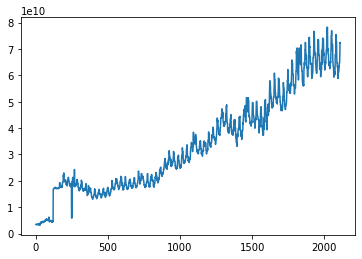

In [4]:
plt.plot(df.VALUE)

Мы видим выбросы.

Проведём сглаживание временного ряда (за период возьмём месяц, поскольку предсказания нужно сделать в расчёте на 1 месяц):

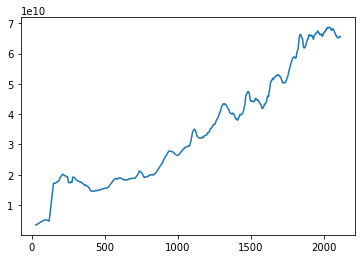

In [5]:
df1 = df.rolling(window=30).mean().dropna()
plt.plot(df1.VALUE)

Временной ряд имеет положительную тенденцию, т.е. не является стационарным.

Это показывает и результат теста Дики-Фуллера

In [6]:
X = df1.VALUE
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.343038
p-value: 0.919184
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Определим порядок интегрированного ряда:

In [7]:
df1diff = df1.diff(periods=1).dropna()
df1diff

,VALUE
30,-5.827196e+06
31,-2.060094e+06
32,3.054965e+07
33,3.054965e+07
34,3.054965e+07
...,...
2106,-1.065759e+08
2107,-5.707094e+07
2108,1.988776e+07
2109,1.434834e+08


In [8]:
X_diff = df1diff.VALUE
result_log = adfuller(X_diff)

print('ADF Statistic: %f' % result_log[0])
print('p-value: %f' % result_log[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.327816
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


С вероятностью 99% можем отклонить нулевую гипотезу (о том, что ряд нестационарный)

Исходный ряд - интегрированный ряд первого порядка

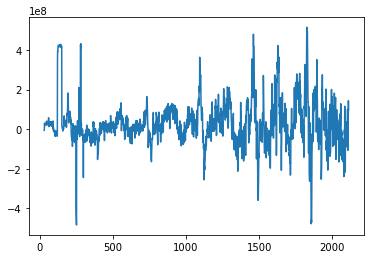

In [9]:
plt.plot(df1diff)

Проверим нормальность распределения.

Для начала построим гистаграмму:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC157DA148>]],
      dtype=object)

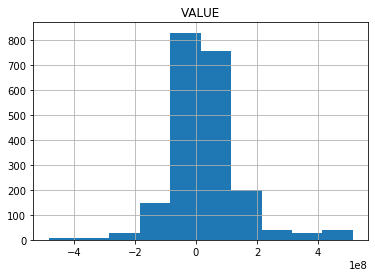

In [10]:
df1diff.hist()

По графику видно, что распредление похоже на нормальное

Проверим нормальность распределения с помощью теста Харке-Бера:

In [11]:
jb_test = sm.stats.stattools.jarque_bera(df1diff)

a = np.vstack([jb_test])
a = a.flatten()
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
print(row, a, sep='\n')

['JB', 'p-value', 'skew', 'kurtosis']
[1.6164001e+03 0.0000000e+00 7.3302816e-01 7.0610943e+00]


p-value близка к 0, поэтому мы можем отвергнуть гипотезу о ненормальности распредления

Найдём количество автокорреляционных коэффициентов:

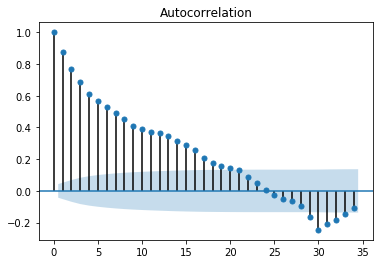

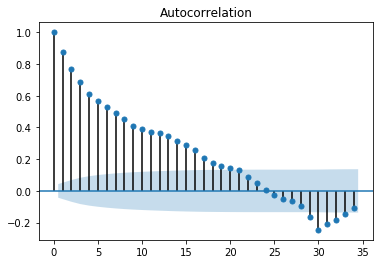

In [12]:
plot_acf(df1diff)

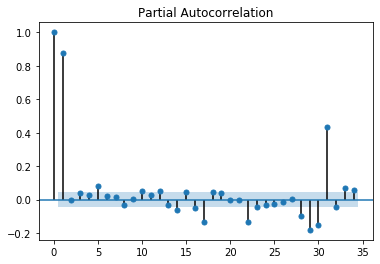

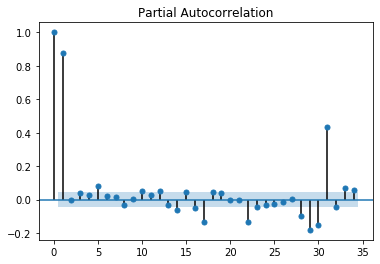

In [13]:
plot_pacf(df1diff)

### Построение модели ARIMA:

Делим датасет на train и test:

In [14]:
train = df[:-30]
test = df[-30:]

Определяем функцию для подсчёта метрик:

In [15]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})



Обучение модели:

In [24]:
model = pm.auto_arima(train.VALUE,
                      test='adf',       # use adftest to find optimal 'd'
                      start_p=6, start_q=2,
                      max_p=6, max_q=2,
                      d=1,
                      seasonal=False,   
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(6,1,2)(0,0,0)[0] intercept   : AIC=93038.140, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=93100.492, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=93083.249, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=93085.070, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=93099.794, Time=0.04 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=93040.903, Time=1.80 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=93052.202, Time=1.70 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=93074.595, Time=1.27 sec
 ARIMA(6,1,2)(0,0,0)[0]             : AIC=92876.891, Time=4.32 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=93011.926, Time=1.71 sec
 ARIMA(6,1,1)(0,0,0)[0]             : AIC=93075.387, Time=1.32 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=93073.387, Time=0.96 sec

Best model:  ARIMA(6,1,2)(0,0,0)[0]          
Total fit time: 15.325 seconds
                               SARIMAX Results                             

Проверка качества:

In [25]:
predicts = model.predict(n_periods = 30)
predictions = pd.DataFrame(predicts)
predictions.set_index(test.index, inplace=True)
predictions.columns = ['predict']

In [26]:
forecast_accuracy(predicts, test.VALUE)

{'mape': 0.02333022199946955,
 'me': -800142109.6806495,
 'mae': 1616742104.5764112,
 'mpe': -0.010367147421729842,
 'rmse': 2308149692.546838,
 'corr': 0.9282270787095893,
 'minmax': 0.02317266002444396}

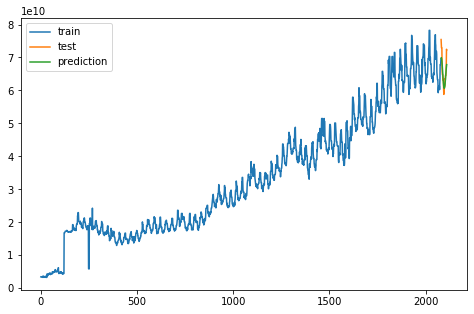

In [28]:
plt.figure(figsize=(8,5))
plt.plot(train.VALUE, label='train')
plt.plot(test.VALUE, label='test')
plt.plot(predictions.predict, label='prediction')
plt.legend()
plt.show()

### Предсказания

Построим предсказания по остатку денедных средств на расчётных счетах на месяц, 2 месяца, 3 месяца и 4 месяца

In [29]:
res_30 = model.predict(30)
res_60 = model.predict(60)[-30:]
res_90 = model.predict(90)[-30:]
res_120 = model.predict(120)[-30:]

res = []
res.extend(res_30)
res.extend(res_60)
res.extend(res_90)
res.extend(res_120)

res_df = pd.DataFrame(res)
res_df.columns = ['prediction']
start = train.index[-1] + 1
res_df.set_index(np.arange(start=start, stop=start+120), inplace=True)

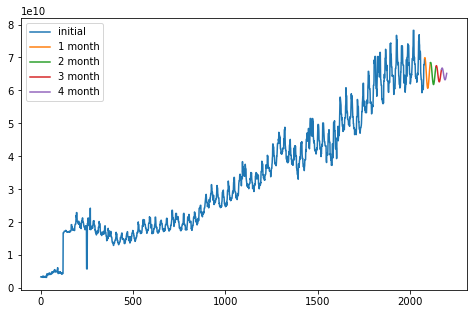

In [30]:
plt.figure(figsize=(8,5))
plt.plot(train.VALUE, label='initial')
plt.plot(res_df.prediction[:31], label='1 month')
plt.plot(res_df.prediction[31:61], label='2 month')
plt.plot(res_df.prediction[61:91], label='3 month')
plt.plot(res_df.prediction[91:], label='4 month')
plt.legend()
plt.show()